In [1]:
!pip install kaggle

In [2]:
# Upload kaggle.json
from google.colab import files
files.upload()

# Put kaggle.json in the right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d yasserhessein/tuberculosis-chest-x-rays-images

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/tuberculosis-chest-x-rays-images
License(s): CC-BY-SA-4.0
  0% 0.00/26.3M [00:00<?, ?B/s]
100% 26.3M/26.3M [00:00<00:00, 1.13GB/s]


In [4]:
!unzip -q tuberculosis-chest-x-rays-images.zip -d /content/tuberculosis-chest-x-rays-images.zipt

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [6]:
DATA_DIR = r'/content/tuberculosis-chest-x-rays-images.zipt/Dataset of Tuberculosis Chest X-rays Images' # e.g., './dataset/'
CATEGORIES = ['Normal Chest X-rays', 'TB Chest X-rays']
IMG_SIZE = 224 # Image size for models like ResNet50, VGG16
BATCH_SIZE = 32


In [7]:
# --- Loading Data ---
def load_data(data_dir, img_size, categories):
    """Loads images and labels from the specified directory."""
    data = []
    labels = []
    for category_id, category in enumerate(categories):
        path = os.path.join(data_dir, category)
        for img_path in os.listdir(path):
            try:
                img_array = tf.keras.preprocessing.image.load_img(
                    os.path.join(path, img_path),
                    target_size=(img_size, img_size)
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img_array)
                data.append(img_array)
                labels.append(category_id)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(data), np.array(labels)

In [8]:
# --- Load and Split Data ---
images, labels = load_data(DATA_DIR, IMG_SIZE, CATEGORIES)


In [9]:
# Normalize pixel values to be between 0 and 1
images = images / 255.0

In [10]:
# Split data into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Split temp data into validation (50% of temp -> 10% of total) and test (50% of temp -> 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training images: {X_train.shape}")
print(f"Validation images: {X_val.shape}")
print(f"Test images: {X_test.shape}")


Training images: (2406, 224, 224, 3)
Validation images: (301, 224, 224, 3)
Test images: (301, 224, 224, 3)


In [11]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

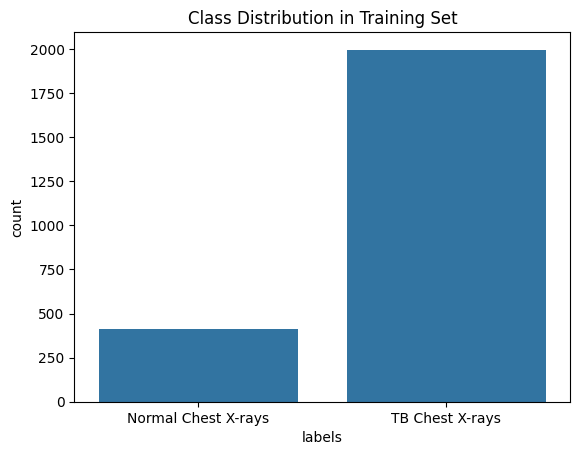

In [12]:
# --- Class Distribution ---
df_labels = pd.DataFrame({'labels': y_train})
sns.countplot(x='labels', data=df_labels)
plt.title("Class Distribution in Training Set")
plt.xticks(ticks=[0, 1], labels=CATEGORIES)
plt.show()

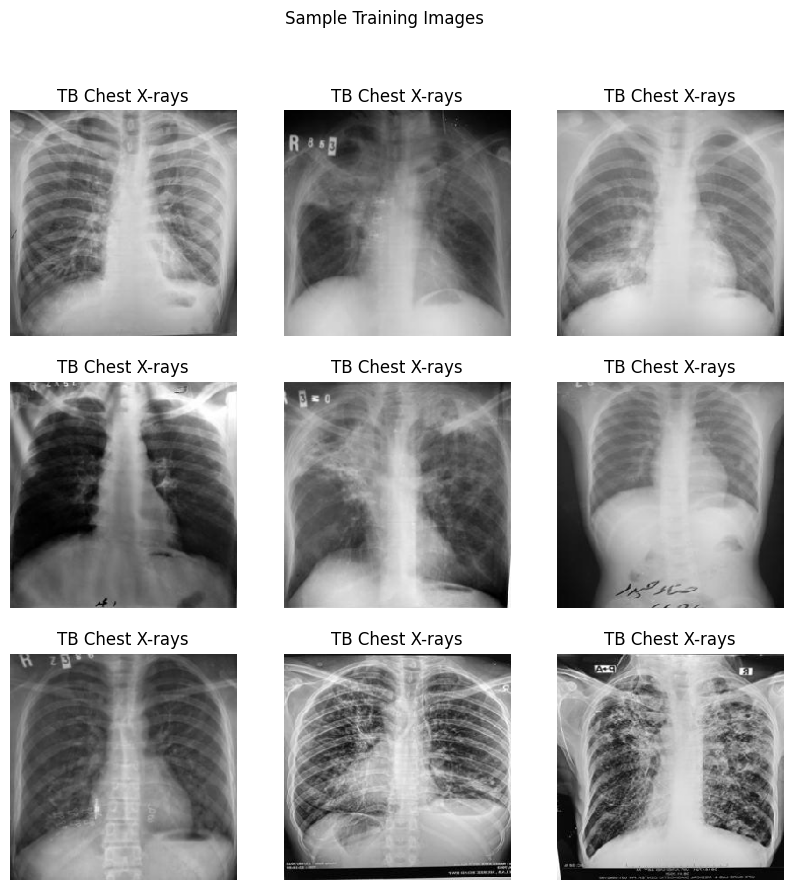

In [13]:
# --- Display Sample Images ---
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(CATEGORIES[y_train[i]])
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

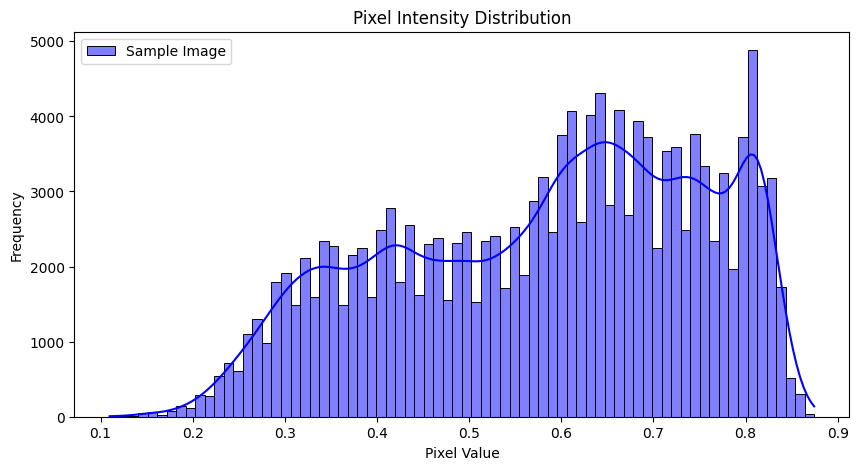

In [14]:
# --- Pixel Intensity Distribution ---
plt.figure(figsize=(10, 5))
sns.histplot(X_train[0].flatten(), color='blue', label='Sample Image', kde=True)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [15]:
# --- Model Configuration ---
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
LEARNING_RATE = 0.0001

In [16]:
# --- Build Model ---
def create_model(img_shape, num_classes):
    """Creates a model using ResNet50 for transfer learning."""
    # Define input layer including the data augmentation
    inputs = Input(shape=img_shape)
    x = data_augmentation(inputs)

    # Load pre-trained ResNet50 model
    base_model = ResNet50(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze base model layers

    # Pass augmented input through the base model
    x = base_model(x, training=False)

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) # Regularization
    outputs = Dense(num_classes, activation='softmax')(x) # Output layer

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = create_model(IMG_SHAPE, len(CATEGORIES))

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', # Use 'binary_crossentropy' for 2 classes
    metrics=['accuracy']
)

model.summary()

# --- Train the Model ---
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 587s 8s/step - accuracy: 0.5159 - loss: 0.9399 - val_accuracy: 0.8306 - val_loss: 0.4547
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 624s 8s/step - accuracy: 0.7396 - loss: 0.6423 - val_accuracy: 0.8306 - val_loss: 0.4725
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 635s 8s/step - accuracy: 0.7718 - loss: 0.6087 - val_accuracy: 0.8306 - val_loss: 0.4686
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 568s 7s/step - accuracy: 0.7835 - loss: 0.5790 - val_accuracy: 0.8306 - val_loss: 0.4648
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 569s 7s/step - accuracy: 0.7879 - loss: 0.5792 - val_accuracy: 0.8306 - val_loss: 0.4660


10/10 ━━━━━━━━━━━━━━━━━━━━ 59s 6s/step - accuracy: 0.8310 - loss: 0.4656
Test Accuracy: 0.83
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.00      0.00      0.00        52
    TB Chest X-rays       0.83      1.00      0.91       249

           accuracy                           0.83       301
          macro avg       0.41      0.50      0.45       301
       weighted avg       0.68      0.83      0.75       301



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


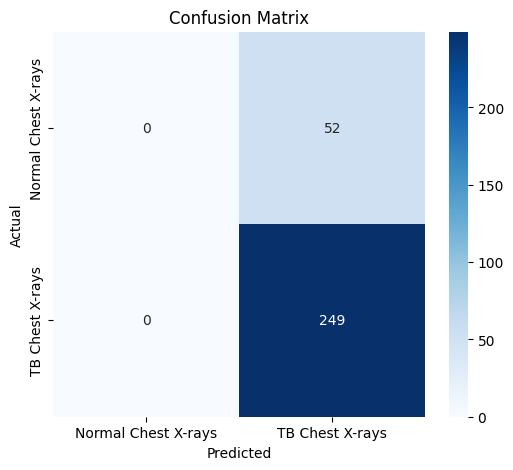

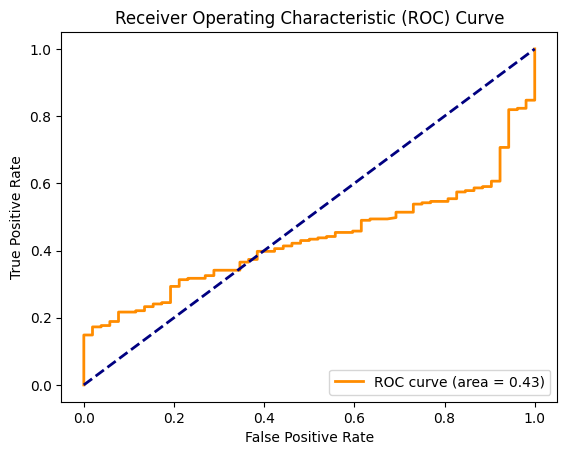

In [17]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# --- Evaluate on Test Data ---
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# --- Get Predictions ---
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# --- Classification Report (Precision, Recall, F1-Score) ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- ROC-AUC Curve ---
# Note: ROC is typically for binary classification. For multi-class, use one-vs-rest.
# This example assumes binary classification (normal vs. tb).
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# --- Build Model ---
def create_model(img_shape, num_classes):
    """Creates a model using VGG16 for transfer learning."""
    # Define input layer including the data augmentation
    inputs = Input(shape=img_shape)
    x = data_augmentation(inputs)

    # Load pre-trained ResNet50 model
    base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze base model layers

    # Pass augmented input through the base model
    x = base_model(x, training=False)

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) # Regularization
    outputs = Dense(num_classes, activation='softmax')(x) # Output layer

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = create_model(IMG_SHAPE, len(CATEGORIES))

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', # Use 'binary_crossentropy' for 2 classes
    metrics=['accuracy']
)

model.summary()

# --- Train the Model ---
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1852s 24s/step - accuracy: 0.5151 - loss: 0.7672 - val_accuracy: 0.8306 - val_loss: 0.5093
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1945s 25s/step - accuracy: 0.7091 - loss: 0.5681 - val_accuracy: 0.8306 - val_loss: 0.4507
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1914s 25s/step - accuracy: 0.8127 - loss: 0.4899 - val_accuracy: 0.8306 - val_loss: 0.4387
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1885s 24s/step - accuracy: 0.8273 - loss: 0.4622 - val_accuracy: 0.8306 - val_loss: 0.4334
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1847s 24s/step - accuracy: 0.8204 - loss: 0.4692 - val_accuracy: 0.8306 - val_loss: 0.4282


In [20]:
# Save the trained model
model.save('tb_classifier_resnet50.keras')

10/10 ━━━━━━━━━━━━━━━━━━━━ 200s 20s/step - accuracy: 0.8310 - loss: 0.4264
Test Accuracy: 0.83
10/10 ━━━━━━━━━━━━━━━━━━━━ 201s 20s/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.00      0.00      0.00        52
    TB Chest X-rays       0.83      1.00      0.91       249

           accuracy                           0.83       301
          macro avg       0.41      0.50      0.45       301
       weighted avg       0.68      0.83      0.75       301



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


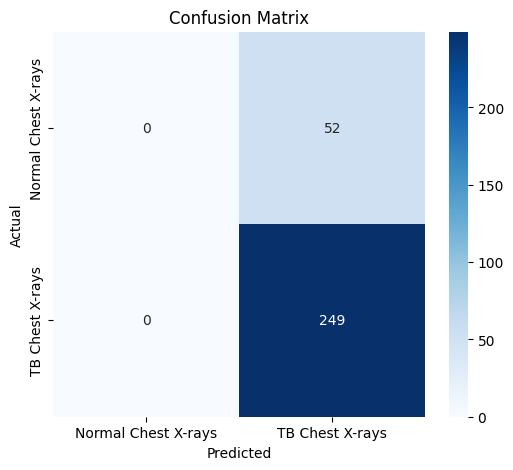

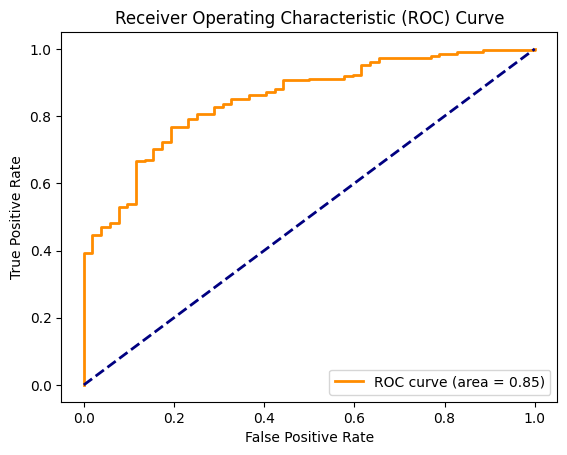

In [19]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# --- Evaluate on Test Data ---
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# --- Get Predictions ---
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# --- Classification Report (Precision, Recall, F1-Score) ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- ROC-AUC Curve ---
# Note: ROC is typically for binary classification. For multi-class, use one-vs-rest.
# This example assumes binary classification (normal vs. tb).
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
# --- Build Model ---
def create_model(img_shape, num_classes):
    """Creates a model using EfficientNetB0 for transfer learning."""
    # Define input layer including the data augmentation
    inputs = Input(shape=img_shape)
    x = data_augmentation(inputs)

    # Load pre-trained ResNet50 model
    base_model = EfficientNetB0(input_shape=img_shape, include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze base model layers

    # Pass augmented input through the base model
    x = base_model(x, training=False)

    # Add custom top layers for classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) # Regularization
    outputs = Dense(num_classes, activation='softmax')(x) # Output layer

    model = Model(inputs, outputs)
    return model

# Create and compile the model
model = create_model(IMG_SHAPE, len(CATEGORIES))

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', # Use 'binary_crossentropy' for 2 classes
    metrics=['accuracy']
)

model.summary()

# --- Train the Model ---
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.7379 - loss: 0.5742 - val_accuracy: 0.8306 - val_loss: 0.4550
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.8111 - loss: 0.5049 - val_accuracy: 0.8306 - val_loss: 0.4564
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.8298 - loss: 0.4750 - val_accuracy: 0.8306 - val_loss: 0.4551
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.8176 - loss: 0.4923 - val_accuracy: 0.8306 - val_loss: 0.4567
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.8278 - loss: 0.4698 - val_accuracy: 0.8306 - val_loss: 0.4553


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8310 - loss: 0.4546
Test Accuracy: 0.83
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step

Classification Report:
                     precision    recall  f1-score   support

Normal Chest X-rays       0.00      0.00      0.00        52
    TB Chest X-rays       0.83      1.00      0.91       249

           accuracy                           0.83       301
          macro avg       0.41      0.50      0.45       301
       weighted avg       0.68      0.83      0.75       301



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


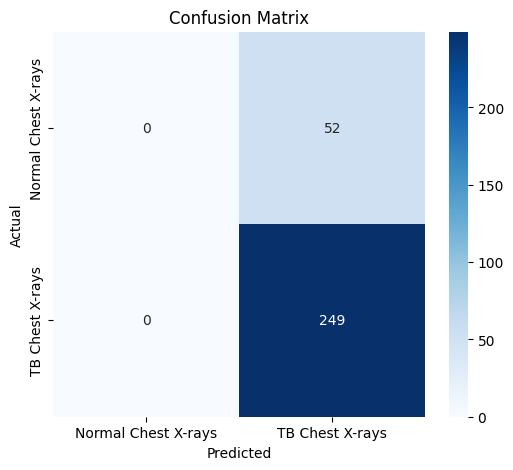

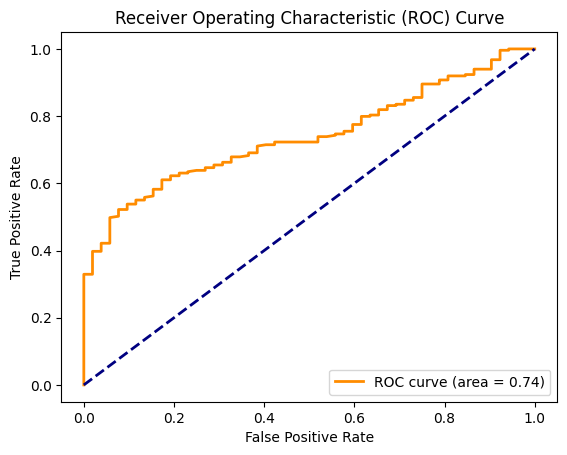

In [17]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix

# --- Evaluate on Test Data ---
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.2f}")

# --- Get Predictions ---
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# --- Classification Report (Precision, Recall, F1-Score) ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- ROC-AUC Curve ---
# Note: ROC is typically for binary classification. For multi-class, use one-vs-rest.
# This example assumes binary classification (normal vs. tb).
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
%%writefile model.py
!pip install streamlit
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np


choice=st.sidebar.selectbox('Navigator',['Introduction','TB X-Ray Prediction','About Me'])
if choice=='Introduction':
    st.title('Tuberculosis X-rays Classification')
    st.image('images.jpeg')
    st.subheader('The system will preprocess and augment image data, train multiple deep learning models, and evaluate their performance. The final application will provide an interface for uploading X-ray images and receiving predictions')

elif choice=='TB X-Ray Prediction':
    MODEL_PATH = 'tb_classifier_resnet50.keras'
    IMG_SIZE = 224
    CATEGORIES = ['Normal', 'Tuberculosis']

    # --- Load Model ---
    @st.cache_resource
    def load_model(path):
        """Loads the pre-trained Keras model."""
        try:
            model = tf.keras.models.load_model(path)
            return model
        except Exception as e:
            st.error(f"Error loading model: {e}")
            return None

    model = load_model(MODEL_PATH)

    # --- UI Elements ---
    st.title("🫁 TB X-Ray Image Classification")
    st.write("Upload a chest X-ray image to classify it as Normal or containing Tuberculosis.")

    uploaded_file = st.file_uploader("Choose an X-ray image...", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None and model is not None:
        # --- Preprocess Image ---
        image = Image.open(uploaded_file).convert('RGB')
        st.image(image, caption='Uploaded Image', use_column_width=True)

        # Resize and normalize
        image_resized = image.resize((IMG_SIZE, IMG_SIZE))
        img_array = tf.keras.preprocessing.image.img_to_array(image_resized)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch
        img_array /= 255.0

        # --- Make Prediction ---
        with st.spinner('Classifying...'):
            prediction = model.predict(img_array)
            score = tf.nn.softmax(prediction[0])
            class_index = np.argmax(score)
            class_name = CATEGORIES[class_index]
            confidence = 100 * np.max(score)

        # --- Display Result ---
        st.success(f"**Prediction:** {class_name}")
        st.info(f"**Confidence:** {confidence:.2f}%")

elif choice=='About Me':
    st.title('👩‍💻Creator Info')
    st.image('AboutMe.webp')
    st.write("""
    Developed by: Simran Paul
    email: simranpaul1010@gmail.com

    *Skills : Computer Vision, Deep Learning , Pyhton

    I am very passionate to grasp new skills and very quick adaptive to learning environment!!
    """)

Overwriting model.py


In [28]:
!streamlit run model.py


/bin/bash: line 1: streamlit: command not found


In [29]:
%%writefile model.py
import os
import time
import numpy as np
import streamlit as st
import tensorflow as tf
from PIL import Image

# ---------------------------
# Page Config
# ---------------------------
st.set_page_config(
    page_title="TB X-ray Classifier",
    page_icon="🫁",
    layout="centered",
)

# Optional: make GPU memory growth safe if running on GPU
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# ---------------------------
# App Constants
# ---------------------------
MODEL_PATH = "tb_classifier_resnet50.keras"
IMG_SIZE = 224
CATEGORIES = ['Normal', 'Tuberculosis']  # Must match training label order

# ---------------------------
# Helpers
# ---------------------------
@st.cache_resource(show_spinner=True)
def load_model(path: str):
    """Load a compiled Keras model from disk."""
    model = tf.keras.models.load_model(path)
    return model

def preprocess_image_pil(pil_img: Image.Image, target_size: int = 224) -> np.ndarray:
    """Resize -> to array -> scale to [0,1] -> add batch dim."""
    img = pil_img.convert("RGB").resize((target_size, target_size))
    arr = tf.keras.preprocessing.image.img_to_array(img)
    arr = arr.astype("float32") / 255.0
    arr = np.expand_dims(arr, axis=0)
    return arr

def predict_with_softmax(model: tf.keras.Model, batch: np.ndarray) -> np.ndarray:
    """
    Returns softmax probabilities regardless of model's final activation.
    If your model already ends with softmax, this is still fine.
    """
    logits = model.predict(batch, verbose=0)
    # Ensure 2D
    if logits.ndim == 1:
        logits = np.expand_dims(logits, 0)
    # If already sums ~1, treat as probs; else softmax
    row_sums = np.sum(logits, axis=1, keepdims=True)
    if np.allclose(row_sums, 1.0, atol=1e-3) and np.all(logits >= 0):
        probs = logits
    else:
        probs = tf.nn.softmax(logits, axis=1).numpy()
    return probs

def gradcam_heatmap(model: tf.keras.Model, img_tensor: np.ndarray, last_conv_name: str = "conv5_block3_out"):
    """
    Compute Grad-CAM for ResNet50-style models.
    - img_tensor: (1, H, W, 3) preprocessed to match training
    """
    try:
        last_conv_layer = model.get_layer(last_conv_name)
    except ValueError:
        return None  # layer not found

    # Build a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the target class wrt last conv layer
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        return None

    # Global average pool the gradients over width and height
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight the channels by importance
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU and normalize to [0,1]
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    # Resize heatmap to input image size
    heatmap = tf.image.resize(
        heatmap[..., np.newaxis],
        (IMG_SIZE, IMG_SIZE)
    ).numpy().squeeze()

    return heatmap  # float32 [0,1] (H,W)

def overlay_heatmap_on_image(pil_img: Image.Image, heatmap: np.ndarray, alpha: float = 0.35) -> Image.Image:
    """
    Overlay a grayscale heatmap onto the original RGB image.
    """
    if heatmap is None:
        return None
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    heatmap_img = Image.fromarray(heatmap_uint8, mode="L").resize(pil_img.size)
    heatmap_img = heatmap_img.convert("RGBA")
    # Convert grayscale to pseudo-color using PIL (apply a simple palette)
    heatmap_img = heatmap_img.convert("P")  # palettized
    heatmap_img.putpalette([
        # Simple palette: from black to red to yellow to white (256 entries)
        # We'll just set a gradient; PIL will interpolate
        *(list(np.linspace(0, 255, 256).astype(np.uint8)) + [0]*256 + [0]*256)
    ])
    heatmap_img = heatmap_img.convert("RGBA")

    base = pil_img.convert("RGBA")
    blended = Image.blend(base, heatmap_img, alpha=alpha)
    return blended.convert("RGB")

# ---------------------------
# Sidebar Navigation
# ---------------------------
st.sidebar.title("Navigator")
choice = st.sidebar.selectbox('Go to', ['Introduction', 'TB X-Ray Prediction', 'About Me'])

# ---------------------------
# Pages
# ---------------------------
if choice == 'Introduction':
    st.title('Tuberculosis X-rays Classification')
    if os.path.exists('images.jpeg'):
        st.image('images.jpeg', use_column_width=True)
    else:
        st.warning("Cover image `images.jpeg` not found in the working directory.")
    st.subheader(
        'This system preprocesses and augments image data, applies deep learning models, '
        'and provides an interface to upload chest X-ray images and receive predictions.'
    )
    st.markdown(
        "- ✅ Transfer learning (ResNet50)\n"
        "- ✅ Clean UI with class probabilities\n"
        "- ✅ Optional Grad-CAM heatmap for explainability"
    )

elif choice == 'TB X-Ray Prediction':
    st.title("🫁 TB X-Ray Image Classification")
    st.write("Upload a chest X-ray image to classify it as **Normal** or **Tuberculosis**.")

    # Load the model (with spinner)
    if not os.path.exists(MODEL_PATH):
        st.error(f"Model file `{MODEL_PATH}` not found. Place it next to `model.py`.")
        st.stop()

    with st.spinner("Loading model..."):
        try:
            model = load_model(MODEL_PATH)
        except Exception as e:
            st.error(f"Error loading model: {e}")
            st.stop()

    uploaded_file = st.file_uploader("Choose an X-ray image...", type=["jpg", "jpeg", "png"])
    show_heatmap = st.checkbox("Show Grad-CAM heatmap (experimental)", value=False)

    if uploaded_file is not None:
        try:
            image = Image.open(uploaded_file).convert('RGB')
        except Exception as e:
            st.error(f"Could not read image: {e}")
            st.stop()

        st.image(image, caption='Uploaded Image', use_column_width=True)

        # Preprocess
        batch = preprocess_image_pil(image, target_size=IMG_SIZE)

        # Predict
        start = time.time()
        probs = predict_with_softmax(model, batch)
        infer_time = (time.time() - start) * 1000.0  # ms

        # Decode
        class_index = int(np.argmax(probs[0]))
        class_name = CATEGORIES[class_index]
        confidence = float(np.max(probs[0])) * 100.0

        # Display
        st.success(f"**Prediction:** {class_name}")
        st.info(f"**Confidence:** {confidence:.2f}%")
        st.caption(f"Inference time: {infer_time:.1f} ms")

        # Probability table
        st.write("Class probabilities:")
        prob_table = {CATEGORIES[i]: f"{probs[0][i]*100:.2f}%" for i in range(len(CATEGORIES))}
        st.table(prob_table)

        # Optional Grad-CAM
        if show_heatmap:
            with st.spinner("Generating Grad-CAM..."):
                heatmap = gradcam_heatmap(model, batch, last_conv_name="conv5_block3_out")
                if heatmap is None:
                    st.warning("Grad-CAM unavailable (layer not found or gradients not traceable).")
                else:
                    overlay = overlay_heatmap_on_image(image.resize((IMG_SIZE, IMG_SIZE)), heatmap, alpha=0.35)
                    st.image(overlay, caption="Grad-CAM Overlay", use_column_width=True)

elif choice == 'About Me':
    st.title('👩‍💻 Creator Info')
    if os.path.exists('AboutMe.webp'):
        st.image('AboutMe.webp', width=220)
    else:
        st.warning("Image `AboutMe.webp` not found.")
    st.markdown("""
**Developed by:** Simran Paul
**Email:** simranpaul1010@gmail.com

**Skills:** Computer Vision, Deep Learning, Python

I’m passionate about learning fast and building practical AI applications!
""")


Overwriting model.py
